<a href="https://colab.research.google.com/github/AsmaaYassinDev/Context-Aware-Fraud-Detection/blob/main/train_ablation_comparison_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload 'kaggle.json':


Saving kaggle.json to kaggle.json
Loading Data...


/tmp/ipython-input-4049651019.py:41: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-4049651019.py:41: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-4049651019.py:41: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-4049651019.py:41: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-4049651019.py:41: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-404965

Engineering Features...


/tmp/ipython-input-4049651019.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = (df['TransactionDT'] // 3600) % 24
/tmp/ipython-input-4049651019.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)
/tmp/ipython-input-4049651019.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns


--- STARTING ABLATION TRAINING ---
Calculated Scale Weight: 27.46
Training Standard Model (Weight=1)...
Training Cost-Sensitive Model (Weight=27.5)...

--- GENERATING SLOPE GRAPH ---


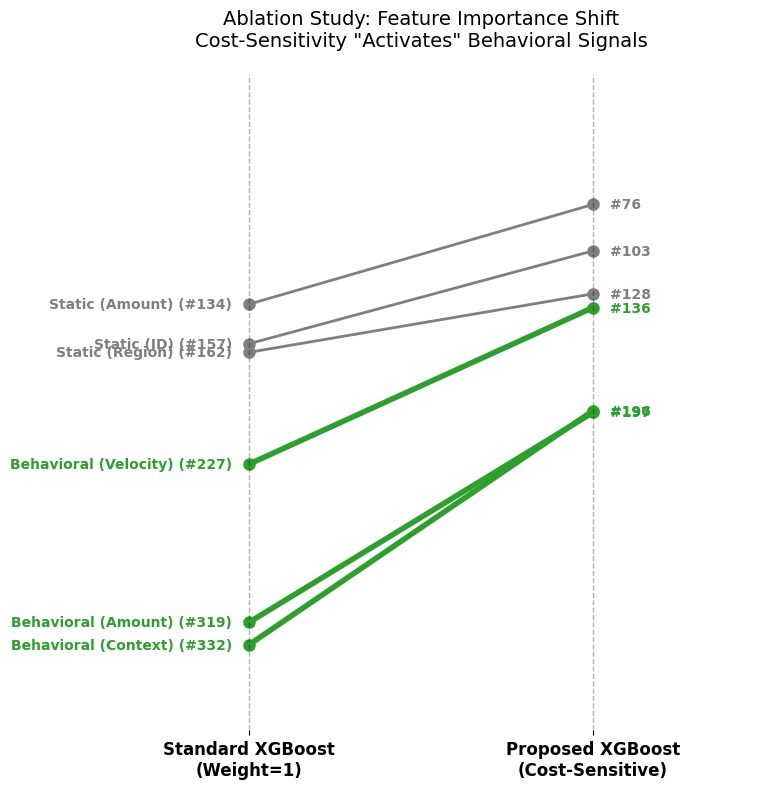

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from google.colab import files
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# =========================================================
# 1. ROBUST DATA LOADING
# =========================================================
def force_download():
    if os.path.exists('train_transaction.csv'):
        print("✅ Data found.")
        return
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload 'kaggle.json':")
        files.upload()
        os.system('mkdir -p ~/.kaggle')
        os.system('cp kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('kaggle competitions download -c ieee-fraud-detection')
    os.system('unzip -o ieee-fraud-detection.zip')
    os.system('unzip -o train_transaction.csv.zip')
    os.system('unzip -o train_identity.csv.zip')

force_download()

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    return df

print("Loading Data...")
train_trans = reduce_mem_usage(pd.read_csv('train_transaction.csv'))
train_id = reduce_mem_usage(pd.read_csv('train_identity.csv'))
df = pd.merge(train_trans, train_id, on='TransactionID', how='left')
del train_trans, train_id
gc.collect()

# =========================================================
# 2. FEATURE ENGINEERING (LEAKAGE-FREE)
# =========================================================
print("Engineering Features...")
df = df.sort_values('TransactionDT').reset_index(drop=True)

# Basic Cleanup
df = df.drop(columns=df.columns[df.isnull().mean() > 0.95])
for col in df.select_dtypes(include=['object']).columns: df[col] = df[col].fillna('Unknown')
for col in df.select_dtypes(exclude=['object']).columns: df[col] = df[col].fillna(-1)

# UID Construction
df['hour'] = (df['TransactionDT'] // 3600) % 24
df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)
df['UID'] = LabelEncoder().fit_transform(df['UID'])

# Behavioral Features (Expanding Window)
df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Amt_Deviation'] = df['TransactionAmt'] / (df['User_Mean_Amt'] + 1e-5)
df['User_Hour_Mean'] = df.groupby(['UID', 'hour'])['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Time_Behavior_Deviation'] = df['TransactionAmt'] / (df['User_Hour_Mean'] + 1e-5)

# Encoding
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# =========================================================
# 3. DUAL MODEL TRAINING (ABLATION STUDY)
# =========================================================
print("\n--- STARTING ABLATION TRAINING ---")
# Use strict 80% split to match paper methodology
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
features = [c for c in df.columns if c not in ['isFraud', 'TransactionID', 'TransactionDT', 'UID', 'User_Mean_Amt', 'User_Hour_Mean']]
X_train, y_train = train_df[features], train_df['isFraud']

# Calculate Weight
neg, pos = np.bincount(y_train)
scale_weight = neg / pos
print(f"Calculated Scale Weight: {scale_weight:.2f}")

# --- MODEL A: STANDARD (Unweighted) ---
# Constraint: scale_pos_weight = 1 (Ignorant of imbalance)
print("Training Standard Model (Weight=1)...")
model_unweighted = xgb.XGBClassifier(
    n_estimators=300,        # Your Config
    max_depth=10,            # Your Config
    learning_rate=0.03,      # Your Config
    subsample=0.8,           # Your Config
    colsample_bytree=0.7,    # Your Config
    scale_pos_weight=1,      # <--- KEY DIFFERENCE (No Cost Sensitivity)
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)
model_unweighted.fit(X_train, y_train)

# --- MODEL B: PROPOSED (Cost-Sensitive) ---
# Constraint: scale_pos_weight = Calculated Weight (Aware of imbalance)
print(f"Training Cost-Sensitive Model (Weight={scale_weight:.1f})...")
model_weighted = xgb.XGBClassifier(
    n_estimators=300,        # Your Config
    max_depth=10,            # Your Config
    learning_rate=0.03,      # Your Config
    subsample=0.8,           # Your Config
    colsample_bytree=0.7,    # Your Config
    scale_pos_weight=scale_weight, # <--- KEY DIFFERENCE (Proposed Method)
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)
model_weighted.fit(X_train, y_train)

# =========================================================
# 4. GENERATING SLOPE GRAPH
# =========================================================
print("\n--- GENERATING SLOPE GRAPH ---")

def get_ranks(model):
    imp = model.get_booster().get_score(importance_type='gain')
    df_imp = pd.DataFrame(list(imp.items()), columns=['Feature', 'Gain'])
    df_imp = df_imp.sort_values('Gain', ascending=False).reset_index(drop=True)
    df_imp['Rank'] = df_imp.index + 1
    return df_imp.set_index('Feature')['Rank']

rank_un = get_ranks(model_unweighted)
rank_w = get_ranks(model_weighted)

# Select specific features to highlight in the chart
features_to_plot = {
    'User_Trans_Count': 'Behavioral (Velocity)',
    'Time_Behavior_Deviation': 'Behavioral (Context)',
    'Amt_Deviation': 'Behavioral (Amount)',
    'TransactionAmt': 'Static (Amount)',
    'card1': 'Static (ID)',
    'addr1': 'Static (Region)'
}

# Prepare Data for Plotting
data = []
for feat, label in features_to_plot.items():
    r1 = rank_un.get(feat, 999) # 999 if dropped by model
    r2 = rank_w.get(feat, 999)

    # Visual Logic: Green for Behavioral (Hypothesis), Gray for Static (Controls)
    color = '#2ca02c' if 'Behavioral' in label else '#7f7f7f'
    width = 4 if 'Behavioral' in label else 2

    data.append({'label': label, 'y1': r1, 'y2': r2, 'color': color, 'width': width})

# PLOTTING
fig, ax = plt.subplots(figsize=(8, 8))

# Draw Lines
for d in data:
    l = mlines.Line2D([0, 1], [d['y1'], d['y2']], color=d['color'], linewidth=d['width'], marker='o', markersize=8)
    ax.add_line(l)

    # Add Labels (Left side - Unweighted)
    ax.text(-0.05, d['y1'], f"{d['label']} (#{d['y1']})", ha='right', va='center', fontsize=10, color=d['color'], fontweight='bold')
    # Add Labels (Right side - Weighted)
    ax.text(1.05, d['y2'], f"#{d['y2']}", ha='left', va='center', fontsize=10, color=d['color'], fontweight='bold')

# Formatting Axes
ax.set_xlim(-0.5, 1.5)
# Invert Y axis so Rank #1 is at the top
ax.set_ylim(max([d['y1'] for d in data] + [d['y2'] for d in data]) + 50, 0)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Standard XGBoost\n(Weight=1)', 'Proposed XGBoost\n(Cost-Sensitive)'], fontsize=12, fontweight='bold')
ax.set_yticks([]) # Hide Y axis numbers for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add Vertical Axis Guidelines
ax.axvline(x=0, color='black', alpha=0.3, linewidth=1, linestyle='--')
ax.axvline(x=1, color='black', alpha=0.3, linewidth=1, linestyle='--')

plt.title('Ablation Study: Feature Importance Shift\nCost-Sensitivity "Activates" Behavioral Signals', fontsize=14, pad=20)
plt.tight_layout()
plt.show()